In [2]:
import os
import pandas as pd
import snowflake.connector
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from dotenv import load_dotenv

In [81]:
load_dotenv()
# Connect to Snowflake
conn = snowflake.connector.connect(
    user= os.getenv("USER"),
    password=os.getenv("PASSWORD"),
    account=os.getenv("ACCOUNT")
)

# Create a cursor object
cur = conn.cursor()

# Select the database and schema
cur.execute("USE DATABASE COVID19_EPIDEMIOLOGICAL_DATA")
cur.execute("USE SCHEMA public")  

In [82]:
#Funcutuin section
def get_data_from_snowflake(sql_querry:str, file_name:str, folder:str = 'data/'):

    if len(file_name)<0: 
            file_name = 'file'

    if not file_name.endswith('.csv'):
        file_name += '.csv'

    file_name = folder + file_name #  Add the directory to the path 

    if os.path.exists(file_name):
        print(f'File {file_name} already exists !')
    else:
        try:
            cur.execute(sql_querry)
        except:
            print("error occured")

        df = cur.fetch_pandas_all()
        
        df.to_csv(file_name, index=False)


def format_func(value, tick_number):
    return f'{int(value):,}'


## DATA COLLECTION

In [83]:
folder = 'COVID19_EPIDEMIOLOGICAL_DATA/'

query = '''
SELECT * FROM COVID19_EPIDEMIOLOGICAL_DATA.PUBLIC.WHO_TIMESERIES
'''
get_data_from_snowflake(
    sql_querry = query,
    file_name =  'WHO_TIMESERIES',
    folder = folder
    )


query = '''
SELECT * FROM COVID19_EPIDEMIOLOGICAL_DATA.PUBLIC.ECDC_GLOBAL
'''
get_data_from_snowflake(
    sql_querry = query, 
    file_name = 'ECDC_GLOBAL',
    folder=folder
    )


query = '''
SELECT * FROM COVID19_EPIDEMIOLOGICAL_DATA.PUBLIC.OWID_VACCINATIONS
'''
get_data_from_snowflake(
    sql_querry = query, 
    file_name = 'OWID_VACCINATIONS',
    folder=folder
    )


query = '''
SELECT * FROM COVID19_EPIDEMIOLOGICAL_DATA.PUBLIC.WHO_SITUATION_REPORTS
'''
get_data_from_snowflake(
    sql_querry = query, 
    file_name = 'WHO_SITUATION_REPORTS',
    folder=folder
    )

query = '''
SELECT
    COUNTRY_REGION,
    DATE,
    CASES
FROM
    JHU_COVID_19
WHERE
    CASE_TYPE = 'Confirmed'
    AND COUNTRY_REGION IN ('United States', 'Brazil', 'Mexico', 'India', 'United Kingdom', 'Italy', 'Russian Federation', 'France', 'Germany', 'Spain')
ORDER BY
    COUNTRY_REGION,
    DATE;
'''
get_data_from_snowflake(
    sql_querry = query,
    file_name = 'JHU_COVID_19',
    folder=folder
    )

File COVID19_EPIDEMIOLOGICAL_DATA/WHO_TIMESERIES.csv already exists !
File COVID19_EPIDEMIOLOGICAL_DATA/ECDC_GLOBAL.csv already exists !
File COVID19_EPIDEMIOLOGICAL_DATA/OWID_VACCINATIONS.csv already exists !
File COVID19_EPIDEMIOLOGICAL_DATA/WHO_SITUATION_REPORTS.csv already exists !
File COVID19_EPIDEMIOLOGICAL_DATA/JHU_COVID_19.csv already exists !


## MAIN DATAFRAME FORMING 

In [84]:

# Reading the CSV data into a DataFrame
df_WHO_TIMESERIES = pd.read_csv(folder + 'WHO_TIMESERIES.csv')
df_ECDC_GLOBAL = pd.read_csv(folder + "ECDC_GLOBAL.csv")
df_OWID_VACCINATIONS = pd.read_csv(folder + "OWID_VACCINATIONS.csv")
df_WHO_SITUATION_REPORTS = pd.read_csv(folder + "WHO_SITUATION_REPORTS.csv")


## Prepare JHU_COVID_19 data, aggregate it to make accurate daily statistics

In [85]:

df_JHU_COVID_19 = pd.read_csv(folder + "JHU_COVID_19.csv")

# Step 1: Convert DATE column to datetime if it's not already
df_JHU_COVID_19['DATE'] = pd.to_datetime(df_JHU_COVID_19['DATE'], errors='coerce')

# Step 2: Sort the dataframe by COUNTRY_REGION, DATE, and CASES
df_JHU_COVID_19 = df_JHU_COVID_19.sort_values(by=['COUNTRY_REGION', 'DATE', 'CASES'])

# Step 3: Group by COUNTRY_REGION and DATE, then take the last (which has the largest CASES value for that day)
df_processed_JHU_COVID_19 = df_JHU_COVID_19.groupby(['COUNTRY_REGION', 'DATE']).last().reset_index()

# Step 4: Rename the CASES column to TOTAL_CASES
df_processed_JHU_COVID_19 = df_processed_JHU_COVID_19.rename(columns={'CASES': 'TOTAL_CASES'})

# Step 5: Select only the necessary columns
df_processed_JHU_COVID_19 = df_processed_JHU_COVID_19[['COUNTRY_REGION', 'DATE', 'TOTAL_CASES']]

## Find top 10 countries by death

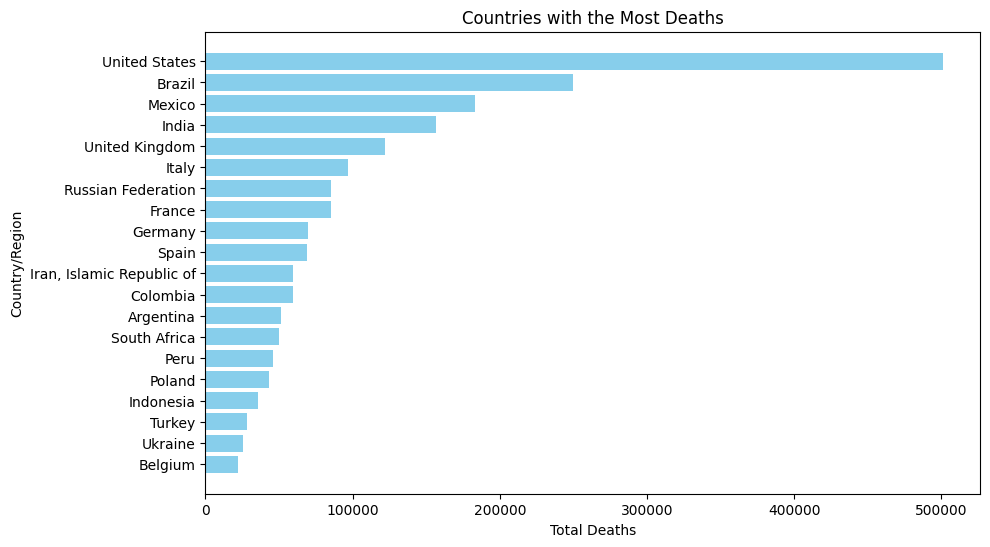

In [86]:

# Sorting the data by DEATHS_TOTAL in descending order
sorted_data = df_WHO_TIMESERIES.sort_values(by='DEATHS_TOTAL', ascending=False)

# Displaying the countries with the most deaths
sorted_data = sorted_data[['COUNTRY_REGION', 'DEATHS_TOTAL']]
filtered_data = sorted_data[sorted_data['COUNTRY_REGION'] != 'Global']
top_20_data = filtered_data.head(20)

# Plotting the countries with the most deaths using matplotlib
plt.figure(figsize=(10, 6))
plt.barh(top_20_data['COUNTRY_REGION'], top_20_data['DEATHS_TOTAL'], color='skyblue')
plt.xlabel('Total Deaths')
plt.ylabel('Country/Region')
plt.title('Countries with the Most Deaths')
plt.gca().invert_yaxis()  # Invert y-axis to show the country with the most deaths at the top
plt.show()

In [87]:
top_10_countries = ["United States", "Brazil", "Mexico", "India", "United Kingdom", "Italy", "France", "Germany", "Spain"] # we will exclude "Russian Federation" because low data amount


## Find top 20 countries by Vaccination

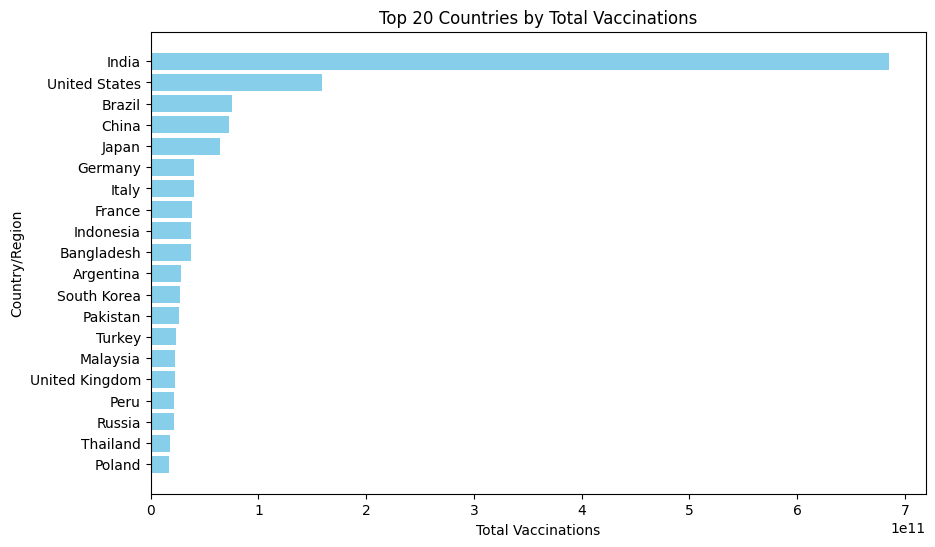

In [88]:
top_20_countries = df_OWID_VACCINATIONS.groupby('COUNTRY_REGION')['PEOPLE_FULLY_VACCINATED'].sum().reset_index()

top_20_countries = top_20_countries.sort_values(by='PEOPLE_FULLY_VACCINATED', ascending=False).head(20)


plt.figure(figsize=(10, 6))
plt.barh(top_20_countries['COUNTRY_REGION'], top_20_countries['PEOPLE_FULLY_VACCINATED'], color='skyblue')
plt.xlabel('Total Vaccinations')
plt.ylabel('Country/Region')
plt.title('Top 20 Countries by Total Vaccinations')
plt.gca().invert_yaxis()  
plt.show()

## Find top 10 countries by death in vaccination statistic

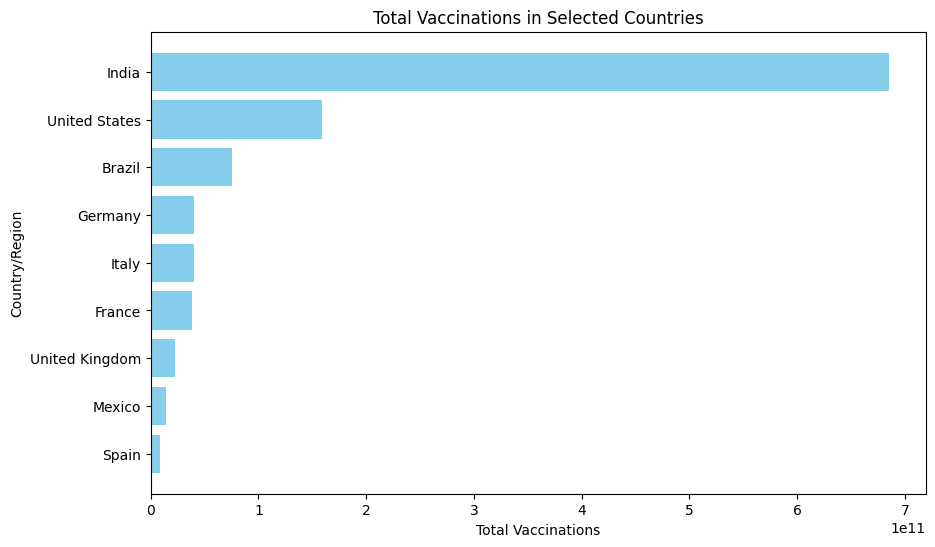

In [89]:
filtered_data = df_OWID_VACCINATIONS[df_OWID_VACCINATIONS['COUNTRY_REGION'].isin(top_10_countries)]

top_countries = filtered_data.groupby('COUNTRY_REGION')['PEOPLE_FULLY_VACCINATED'].sum().reset_index()

top_countries = top_countries.sort_values(by='PEOPLE_FULLY_VACCINATED', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(top_countries['COUNTRY_REGION'], top_countries['PEOPLE_FULLY_VACCINATED'], color='skyblue')
plt.xlabel('Total Vaccinations')
plt.ylabel('Country/Region')
plt.title('Total Vaccinations in Selected Countries')
plt.gca().invert_yaxis() 
plt.show()

## Filter data of dataframes by list of 10 countries

In [90]:
filtered_df_OWID_VACCINATIONS= df_OWID_VACCINATIONS[df_OWID_VACCINATIONS['COUNTRY_REGION'].isin(top_10_countries)]
filtered_df_ECDC_GLOBAL = df_ECDC_GLOBAL[df_ECDC_GLOBAL['COUNTRY_REGION'].isin(top_10_countries)] 
filtered_df_WHO_SITUATION_REPORTS = df_WHO_SITUATION_REPORTS[df_WHO_SITUATION_REPORTS['COUNTRY_REGION'].isin(top_10_countries)] 

## Display the time series for vaccinations, cases, and a combined graph with a shared x-axis

In [91]:

# Function to plot time series for vaccinations, cases, and a combined graph with a shared x-axis
def plot_country_data_plotly(country, vaccinations_df, cases_df):
    # Filter data for the specific country
    country_vaccination_data = vaccinations_df[vaccinations_df['COUNTRY_REGION'] == country]
    country_cases_data = cases_df[cases_df['COUNTRY_REGION'] == country]
    
    # Convert date columns to datetime
    country_vaccination_data['DATE'] = pd.to_datetime(country_vaccination_data['DATE'], errors='coerce')
    country_cases_data['DATE'] = pd.to_datetime(country_cases_data['DATE'], errors='coerce')
    
    # Drop rows with NaT (Not a Time) values after conversion
    country_vaccination_data = country_vaccination_data.dropna(subset=['DATE'])
    country_cases_data = country_cases_data.dropna(subset=['DATE'])
    
    # Ensure there are valid dates to avoid NaN in min_date and max_date
    if not country_vaccination_data.empty and not country_cases_data.empty:
        min_date = min(country_vaccination_data['DATE'].min(), country_cases_data['DATE'].min())
        max_date = max(country_vaccination_data['DATE'].max(), country_cases_data['DATE'].max())

        # Create a subplot with 1 row and 3 columns
        fig = make_subplots(rows=1, cols=3, subplot_titles=("Vaccinations Over Time", "Cases Over Time", "Vaccinations and Cases Combined"))

        # Plot vaccinations
        fig.add_trace(
            go.Scatter(x=country_vaccination_data['DATE'], y=country_vaccination_data['PEOPLE_FULLY_VACCINATED'], mode='lines+markers', 
                       name='Vaccinations', line=dict(color='green')),
            row=1, col=1
        )

        # Plot cases
        fig.add_trace(
            go.Scatter(x=country_cases_data['DATE'], y=country_cases_data['TOTAL_CASES'], mode='lines+markers', 
                       name='Cases', line=dict(color='blue')),
            row=1, col=2
        )

        # Plot combined graph
        fig.add_trace(
            go.Scatter(x=country_vaccination_data['DATE'], y=country_vaccination_data['PEOPLE_FULLY_VACCINATED'], mode='lines+markers', 
                       name='Vaccinations', line=dict(color='green')),
            row=1, col=3
        )
        fig.add_trace(
            go.Scatter(x=country_cases_data['DATE'], y=country_cases_data['TOTAL_CASES'], mode='lines+markers', 
                       name='Cases', line=dict(color='blue')),
            row=1, col=3
        )

        # Update layout
        fig.update_layout(
            title_text=f"Vaccinations and Cases Over Time in {country}",
            showlegend=True,
            height=600,
            width=1600
        )

        # Update axis labels
        fig.update_xaxes(title_text="Date", range=[min_date, max_date])
        fig.update_yaxes(title_text="Total Vaccinations", row=1, col=1)
        fig.update_yaxes(title_text="Total Cases", row=1, col=2)
        fig.update_yaxes(title_text="Count", row=1, col=3)
        
        # Show the plot
        fig.show()

    else:
        print(f"Skipping country {country} due to lack of valid date data.")


for country in top_10_countries:
    plot_country_data_plotly(country, filtered_df_OWID_VACCINATIONS, df_processed_JHU_COVID_19)


C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\3292008052.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\3292008052.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\3292008052.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\3292008052.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\3292008052.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\3292008052.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\3292008052.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\3292008052.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\3292008052.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\3292008052.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\3292008052.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\3292008052.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\3292008052.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\3292008052.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\3292008052.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\3292008052.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\3292008052.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\3292008052.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Calculate correlation between vaccination and cases.

In [92]:
# Function to calculate correlation between cases and vaccinations for a country
def calculate_correlation(country, vaccinations_df, cases_df ):
    # Filter data for the specific country
    country_vaccination_data = vaccinations_df[vaccinations_df['COUNTRY_REGION'] == country]
    country_cases_data = cases_df[cases_df['COUNTRY_REGION'] == country]
    
    # Convert date columns to datetime
    country_vaccination_data['DATE'] = pd.to_datetime(country_vaccination_data['DATE'], errors='coerce')
    country_cases_data['DATE'] = pd.to_datetime(country_cases_data['DATE'], errors='coerce')
    
    # Merge the data on the date to ensure alignment
    merged_data = pd.merge(country_vaccination_data[['DATE', 'PEOPLE_FULLY_VACCINATED']], 
                           country_cases_data[['DATE', 'TOTAL_CASES']], 
                           on='DATE')
    
    # Drop rows with missing data
    merged_data = merged_data.dropna()
    
    # Calculate the correlation
    correlation = merged_data['PEOPLE_FULLY_VACCINATED'].corr(merged_data['TOTAL_CASES'])
    
    return correlation

In [93]:
correlation_results = {}

for country in top_10_countries:
    correlation = calculate_correlation(country, filtered_df_OWID_VACCINATIONS, df_processed_JHU_COVID_19)
    correlation_results[country] = correlation


C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\3620178474.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\3620178474.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\3620178474.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

In [94]:

# Display the results
for country, correlation in correlation_results.items():
    print(f"Correlation between cases and vaccinations in {country}: {correlation:.2f}")

Correlation between cases and vaccinations in United States: 0.76
Correlation between cases and vaccinations in Brazil: 0.93
Correlation between cases and vaccinations in Mexico: 0.94
Correlation between cases and vaccinations in India: 0.86
Correlation between cases and vaccinations in United Kingdom: 0.74
Correlation between cases and vaccinations in Italy: 0.72
Correlation between cases and vaccinations in France: 0.75
Correlation between cases and vaccinations in Germany: 0.67
Correlation between cases and vaccinations in Spain: 0.69


## Let’s use Global covid statistics dataset to compare with and extend data

In [95]:
# Create a cursor object
cur = conn.cursor()

# Select the database and schema
cur.execute("USE DATABASE GLOBAL_COVID_STATISTICS")
cur.execute("USE SCHEMA INSIGHTS")

In [96]:
query = '''
select 
    COUNTRY, 
    ISO_CODE, 
    DATE, 
    TOTAL_DEATHS,
    POPULATION,
    POPULATION_DENSITY, 
    LIFE_EXPECTANCY, 
    TOTAL_CASE, 
    TOTAL_TESTS,
    CARDIOVASC_DEATH_RATE,
    DIABETES_PREVALENCE
from GLOBAL_COVID_STATISTICS.INSIGHTS.COVID19_METRICS_BY_COUNTRY
'''
get_data_from_snowflake(
    sql_querry=query,
    file_name= 'GLOBAL_COVID_STATISTICS',
    folder= 'GLOBAL_COVID_STATISTICS/'
    )

File GLOBAL_COVID_STATISTICS/GLOBAL_COVID_STATISTICS.csv already exists !


In [97]:
# Load the CSV data into a DataFrame
df_GLOBAL_COVID_STATISTICS = pd.read_csv("GLOBAL_COVID_STATISTICS/GLOBAL_COVID_STATISTICS.csv")


## **<font color="red">Comparison of 2 dataset covid cases</font>**


In [98]:
import pandas as pd
import plotly.graph_objs as go

# Function to compare time series of cases from two dataframes using Plotly
def compare_cases_time_series_plotly(country, df1, df2):
    # Filter data for the specific country from both dataframes
    country_data_df1 = df1[df1['COUNTRY_REGION'] == country]
    country_data_df2 = df2[df2['COUNTRY'] == country]
    
    # Convert the DATE column to datetime in both dataframes
    country_data_df1['DATE'] = pd.to_datetime(country_data_df1['DATE'], errors='coerce')
    country_data_df2['DATE'] = pd.to_datetime(country_data_df2['DATE'], errors='coerce')
    
    # Drop rows with NaT (Not a Time) values after conversion
    country_data_df1 = country_data_df1.dropna(subset=['DATE'])
    country_data_df2 = country_data_df2.dropna(subset=['DATE'])
    
    # Sort the data by date in both dataframes
    country_data_df1 = country_data_df1.sort_values(by='DATE')
    country_data_df2 = country_data_df2.sort_values(by='DATE')
    
    # Create the Plotly figure
    fig = go.Figure()

    # Add the first dataframe's cases (red line)
    fig.add_trace(go.Scatter(
        x=country_data_df1['DATE'], 
        y=country_data_df1['TOTAL_CASES'], 
        mode='lines+markers',
        name='COVID19_EPIDEMIOLOGICAL_DATA',
        line=dict(color='red')
    ))

    # Add the second dataframe's cases (blue line)
    fig.add_trace(go.Scatter(
        x=country_data_df2['DATE'], 
        y=country_data_df2['TOTAL_CASE'], 
        mode='lines+markers',
        name='GLOBAL_COVID_STATISTICS',
        line=dict(color='blue')
    ))

    # Update layout
    fig.update_layout(
        title=f'Comparison of Cases Over Time in {country}',
        xaxis_title='Date',
        yaxis_title='Total Cases',
        height=600,
        width=1000,
        showlegend=True
    )

    # Show the plot
    fig.show()


for country in top_10_countries:
    compare_cases_time_series_plotly(country, df_processed_JHU_COVID_19, df_GLOBAL_COVID_STATISTICS)


C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\3700037425.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\3700037425.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\3700037425.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\3700037425.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\3700037425.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\3700037425.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\3700037425.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\3700037425.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\3700037425.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\3700037425.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\3700037425.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\3700037425.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\3700037425.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\3700037425.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\3700037425.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\3700037425.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\3700037425.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\3700037425.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## **CONCLUSIONS ABOUT DATASET**

####    The dataset COVID19_EPIDEMIOLOGICAL_DATA is bad, the data is duplicated in many columns, it provides poor description of tables with low data quality, especially if compared with 2nd dataset GLOBAL_COVID_STATISTICS. The initial thought was that the there is an error in data or in implemented way of displaying but cases like France comparison showed that the data are similar, but in 90% cases the initial dataset is lacking in amount of data, even time-series of death statistics for list of selected countries is too short to make any assumption in the relation to other tables.


## Correlation with the different case data

In [99]:
# Function to calculate correlation between cases and vaccinations for a country
def calculate_correlation(country, vaccinations_df, cases_df ):
    # Filter data for the specific country
    country_vaccination_data = vaccinations_df[vaccinations_df['COUNTRY_REGION'] == country]
    country_cases_data = cases_df[cases_df['COUNTRY'] == country]
    
    # Convert date columns to datetime
    country_vaccination_data['DATE'] = pd.to_datetime(country_vaccination_data['DATE'], errors='coerce')
    country_cases_data['DATE'] = pd.to_datetime(country_cases_data['DATE'], errors='coerce')
    
    # Merge the data on the date to ensure alignment
    merged_data = pd.merge(country_vaccination_data[['DATE', 'PEOPLE_FULLY_VACCINATED']], 
                           country_cases_data[['DATE', 'TOTAL_CASE']], 
                           on='DATE')
    
    # Drop rows with missing data
    merged_data = merged_data.dropna()
    
    # Calculate the correlation
    correlation = merged_data['PEOPLE_FULLY_VACCINATED'].corr(merged_data['TOTAL_CASE'])
    
    return correlation

correlation_results = {}

for country in top_10_countries:
    correlation = calculate_correlation(country, filtered_df_OWID_VACCINATIONS, df_GLOBAL_COVID_STATISTICS)
    correlation_results[country] = correlation


# Display the results
for country, correlation in correlation_results.items():
    print(f"Correlation between cases and vaccinations in {country}: {correlation:.2f}")


C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\2972195753.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\2972195753.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\2972195753.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

Correlation between cases and vaccinations in United States: 0.80
Correlation between cases and vaccinations in Brazil: 0.93
Correlation between cases and vaccinations in Mexico: 0.94
Correlation between cases and vaccinations in India: 0.92
Correlation between cases and vaccinations in United Kingdom: 0.74
Correlation between cases and vaccinations in Italy: 0.72
Correlation between cases and vaccinations in France: 0.75
Correlation between cases and vaccinations in Germany: 0.68
Correlation between cases and vaccinations in Spain: 0.71


C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\2972195753.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\2972195753.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Death and vaccination statistics comparison

In [100]:
import pandas as pd
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Function to plot deaths and vaccinations over time for each country side by side
def plot_deaths_and_vaccinations_side_by_side(country, deaths_df, vaccinations_df):
    # Filter data for the specific country
    country_deaths_data = deaths_df[deaths_df['COUNTRY'] == country]
    country_vaccination_data = vaccinations_df[vaccinations_df['COUNTRY_REGION'] == country]
    
    # Convert the DATE columns to datetime
    country_deaths_data['DATE'] = pd.to_datetime(country_deaths_data['DATE'], errors='coerce')
    country_vaccination_data['DATE'] = pd.to_datetime(country_vaccination_data['DATE'], errors='coerce')
    
    # Drop rows with NaT (Not a Time) values after conversion
    country_deaths_data = country_deaths_data.dropna(subset=['DATE'])
    country_vaccination_data = country_vaccination_data.dropna(subset=['DATE'])
    
    # Sort the data by date to ensure a smooth line
    country_deaths_data = country_deaths_data.sort_values(by='DATE')
    country_vaccination_data = country_vaccination_data.sort_values(by='DATE')
    
    # Create a subplot with 1 row and 2 columns
    fig = make_subplots(rows=1, cols=2, subplot_titles=("Deaths Over Time", "Vaccinations Over Time"))

    # Plot deaths over time
    fig.add_trace(
        go.Scatter(x=country_deaths_data['DATE'], y=country_deaths_data['TOTAL_DEATHS'], mode='lines+markers', 
                   name='Deaths', line=dict(color='red'), marker=dict(color='red')),
        row=1, col=1
    )

    # Plot vaccinations over time
    fig.add_trace(
        go.Scatter(x=country_vaccination_data['DATE'], y=country_vaccination_data['PEOPLE_FULLY_VACCINATED'], mode='lines+markers', 
                   name='Vaccinations', line=dict(color='green'), marker=dict(color='green')),
        row=1, col=2
    )

    # Update layout
    fig.update_layout(
        title_text=f"Deaths and Vaccinations Over Time in {country}",
        showlegend=False,
        height=600,
        width=1200
    )

    # Update axis labels
    fig.update_xaxes(title_text="Date")
    fig.update_yaxes(title_text="Total Deaths", row=1, col=1)
    fig.update_yaxes(title_text="Total Vaccinations", row=1, col=2)
    
    # Show the plot
    fig.show()


for country in top_10_countries:
    plot_deaths_and_vaccinations_side_by_side(country, df_GLOBAL_COVID_STATISTICS, filtered_df_OWID_VACCINATIONS)


C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\1083584809.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\1083584809.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\1083584809.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\1083584809.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\1083584809.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\1083584809.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\1083584809.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\1083584809.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\1083584809.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\1083584809.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\1083584809.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\1083584809.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\1083584809.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\1083584809.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\1083584809.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\1083584809.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\1083584809.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\1083584809.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Comparison of death and vaccination rate by day with combined graphs to see the data trends.

In [101]:
import pandas as pd
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Function to plot daily rates of deaths, vaccinations, and an overlapping combined graph for each country
def plot_daily_rates_with_normalized_combined(country, deaths_df, vaccinations_df):
    # Filter data for the specific country
    country_deaths_data = deaths_df[deaths_df['COUNTRY'] == country]
    country_vaccination_data = vaccinations_df[vaccinations_df['COUNTRY_REGION'] == country]
    
    # Convert the DATE columns to datetime
    country_deaths_data['DATE'] = pd.to_datetime(country_deaths_data['DATE'], errors='coerce')
    country_vaccination_data['DATE'] = pd.to_datetime(country_vaccination_data['DATE'], errors='coerce')
    
    # Drop rows with NaT (Not a Time) values after conversion
    country_deaths_data = country_deaths_data.dropna(subset=['DATE'])
    country_vaccination_data = country_vaccination_data.dropna(subset=['DATE'])
    
    # Sort the data by date to ensure a smooth line
    country_deaths_data = country_deaths_data.sort_values(by='DATE')
    country_vaccination_data = country_vaccination_data.sort_values(by='DATE')
    
    # Calculate daily rates (new deaths and vaccinations per day)
    country_deaths_data['DAILY_DEATHS'] = country_deaths_data['TOTAL_DEATHS'].diff().fillna(0)
    country_vaccination_data['DAILY_VACCINATIONS'] = country_vaccination_data['PEOPLE_FULLY_VACCINATED'].diff().fillna(0)
    
    # Normalize the daily rates for the combined graph
    max_deaths = country_deaths_data['DAILY_DEATHS'].max()
    max_vaccinations = country_vaccination_data['DAILY_VACCINATIONS'].max()
    
    country_deaths_data['NORMALIZED_DEATHS'] = country_deaths_data['DAILY_DEATHS'] / max_deaths
    country_vaccination_data['NORMALIZED_VACCINATIONS'] = country_vaccination_data['DAILY_VACCINATIONS'] / max_vaccinations
    
    # Create a subplot with 1 row and 3 columns
    fig = make_subplots(rows=1, cols=3, subplot_titles=("Daily Deaths", "Daily Vaccinations", "Combined Normalized Daily Deaths and Vaccinations"))

    # Plot daily deaths over time
    fig.add_trace(
        go.Scatter(x=country_deaths_data['DATE'], y=country_deaths_data['DAILY_DEATHS'], mode='lines+markers',
                   name='Daily Deaths', line=dict(color='red'), marker=dict(color='red')),
        row=1, col=1
    )

    # Plot daily vaccinations over time
    fig.add_trace(
        go.Scatter(x=country_vaccination_data['DATE'], y=country_vaccination_data['DAILY_VACCINATIONS'], mode='lines+markers',
                   name='Daily Vaccinations', line=dict(color='green'), marker=dict(color='green')),
        row=1, col=2
    )

    # Plot combined normalized daily deaths and vaccinations
    fig.add_trace(
        go.Scatter(x=country_deaths_data['DATE'], y=country_deaths_data['NORMALIZED_DEATHS'], mode='lines+markers',
                   name='Normalized Deaths', line=dict(color='red'), marker=dict(color='red')),
        row=1, col=3
    )
    fig.add_trace(
        go.Scatter(x=country_vaccination_data['DATE'], y=country_vaccination_data['NORMALIZED_VACCINATIONS'], mode='lines+markers',
                   name='Normalized Vaccinations', line=dict(color='green'), marker=dict(color='green')),
        row=1, col=3
    )

    # Update layout for normalized combined graph
    fig.update_layout(
        title_text=f"Daily Deaths and Vaccinations Over Time in {country}",
        showlegend=True,
        height=600,
        width=1800
    )

    # Update axis labels
    fig.update_xaxes(title_text="Date")
    fig.update_yaxes(title_text="Daily Deaths", row=1, col=1)
    fig.update_yaxes(title_text="Daily Vaccinations", row=1, col=2)
    fig.update_yaxes(title_text="Normalized Values", row=1, col=3)
    
    # Show the plot
    fig.show()

for country in top_10_countries:
    plot_daily_rates_with_normalized_combined(country, df_GLOBAL_COVID_STATISTICS, filtered_df_OWID_VACCINATIONS)


C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\549897585.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\549897585.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\549897585.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\549897585.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\549897585.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\549897585.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\549897585.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\549897585.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\549897585.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\549897585.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\549897585.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\549897585.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\549897585.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\549897585.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\549897585.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\549897585.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\549897585.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\sadLe\AppData\Local\Temp\ipykernel_10512\549897585.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

